In [1]:
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# from lisatools.diagnostic import *
# from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform, Pn5AAKWaveform
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from few.utils.fdutils import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
# frequency domain
few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True), use_gpu=True,
    return_list=True
)

# time domain
td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, odd_len=True), use_gpu=True,
    return_list=True
)

In [4]:
use_gpu = True

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [5]:
def sensitivitYimposed(x, p0,e,intg_timem,a0):
    T = intg_timem 
    dt = 15.0  # seconds
    M = 4.15e6
    a = a0
    mu =x
    p0 = p0
    e0 = e 
    x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
    qK = np.pi/2  # polar spin angle
    phiK = 0.0  # azimuthal viewing angle
    qS = np.pi/2 # polar sky angle
    phiS = 0.0  # azimuthal viewing angle
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt
    )
            # wave5 = few(M, x, p0, e, theta, phi, dist=dist1, dt=dt, T=intg_time) 
    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real) , dt))
    positive_frequency_mask = (freq>=0.0)
    a1= freq[positive_frequency_mask]
    b1=np.abs(fft_TD[positive_frequency_mask])**2
    a=cp.array(a1)
    b=cp.array(b1)
    return a,b

In [6]:
def sensitivitYimposedOnAngles(x, p0,e,intg_timem,a0,qS,phiS,qK,phiK):
    T = intg_timem 
    dt = 15.0  # secondsBrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

    M = 4.15e6
    a = a0
    mu =x
    p0 = p0
    e0 = e 
    x0 = 1.0  # notice this is x_I, not Y. The AAK waveform can convert to Y.
    qK = qK  # polar spin angle
    phiK = phiK # azimuthal viewing angle
    qS = qS # polar sky angle
    phiS = phiS  # azimuthal viewing angle
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0
    

    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt,
    )
            # wave5 = few(M, x, p0, e, theta, phi, dist=dist1, dt=dt, T=intg_time) 
    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real) , dt))
    positive_frequency_mask = (freq>=0.0)
    a1= freq[positive_frequency_mask]
    b1=np.abs(fft_TD[positive_frequency_mask])**2
    a=cp.array(a1)
    b=cp.array(b1)
    return a,b

In [7]:
def power_spectral_density_RCLfit(freq):
    r"""
    Return the effective power spectral density (PSD) of the detector noise
    at a given frequency, according to the analytical fit by Robson, Cornish
    and Liu, :arxiv:`1803.01944`

    INPUT:

    - ``freq`` -- frequency `f` (in `\mathrm{Hz}`)

    OUTPUT:

    - effective power spectral density `S(f)` (in `\mathrm{Hz}^{-1}`)

    EXAMPLES::

        sage: from kerrgeodesic_gw import lisa_detector
        sage: Sn = lisa_detector.power_spectral_density_RCLfit
        sage: Sn(1.e-1)  # tol 1.0e-13
        2.12858262120861e-39
        sage: Sn(1.e-2)  # tol 1.0e-13
        1.44307343517977e-40
        sage: Sn(1.e-3)  # tol 1.0e-13
        1.63410027259543e-38

    """
    p_oms = 2.25e-22 * (1 + (2.e-3/freq)**4)
    p_acc = 9.e-30 * (1 +(4.e-4/freq)**2) * (1 + (freq/8.e-3)**4)
    L = 2.5e9
    f_star = 1.909e-2
    p_n = (p_oms + 2*(1 + np.cos(freq/f_star)**2)*p_acc/(2*(np.pi)*freq)**4)/L**2
    return 10./3.*p_n*(1 + 0.6*(freq/f_star)**2)

In [8]:
gen_wave = GenerateEMRIWaveform("Pn5AAKWaveform")


In [9]:
def data_set(mu, p0, e, intg_timem, a0):
    T = intg_timem 
    dt = 15.0  # seconds
    M = 4.15e6
    a = a0
    mu = mu
    p0 = p0
    e0 = e 
    x0 = 1.0
    qK = np.pi / 2
    phiK = 0.0
    qS = np.pi / 2
    phiS = 0.0
    dist = 0.000008277 
    Phi_phi0 = 0.0
    Phi_theta0 = 0.0
    Phi_r0 = 0.0

    h = gen_wave(
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        T=T,
        dt=dt
    )
    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real), dt))
    positive_frequency_mask = (freq >= 0.0)
    a1 = freq[positive_frequency_mask]
    b1 = np.abs(fft_TD[positive_frequency_mask]) ** 2
    b2 = np.abs(fft_TDX[positive_frequency_mask]) ** 2
    pluspart = np.abs(fft_TD)**2
    crosspart = np.abs(fft_TDX)**2
    df = freq[1] - freq[0]
    integralp = np.zeros(len(pluspart))
    numerator = pluspart + crosspart
    denominator = power_spectral_density_RCLfit(freq)
    
    for i in range(len(numerator)):
        integralp[i] = numerator[i] / denominator[i]
    
    snr = np.sqrt((4 * np.sum(integralp) * df))


    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    # ax1.plot(h.real[:300], label=r'$ h_{+} $')
    # ax1.plot(h.imag[:300], label=r'$ h_{x} $')
    # ax1.set_xlabel('Time')
    # ax1.set_ylabel('Amplitude')
    # ax1.set_title(f'p0 = {p0}, eccentricity = {e0}')
    # ax1.legend()
    # ax2.plot(freq[positive_frequency_mask], fft_TD[positive_frequency_mask], label=r'$ |FFT(h_+)|$')
    # ax2.plot(freq[positive_frequency_mask], fft_TDX[positive_frequency_mask], label=r'$ |FFT(h_X)$')
    # ax2.set_xlim(0, 0.0025)
    # ax2.set_xlabel('Frequency')
    # ax2.set_ylabel('Amplitude')
    # ax2.set_title('Fourier Transform')
    # ax2.legend()

    # plt.show()

    return a0, e, p0, a1, b1, b2 , h.real, h.imag, freq, fft_TD, fft_TDX, snr

# Example usage
r1 = data_set(5e-2, 12.0, 0.002, 1/365, 0.1)

In [10]:
T = 0.5 
dt = 15.0  # seconds
M = 4.15e6
# a = arr
mu = 5e-2
p0 =8.0
e0 = 0.0 
x0 = 1.0
qK = np.pi / 2
phiK = 0.0
qS = np.pi / 2
phiS = 0.0
dist = 0.000008277 
Phi_phi0 = 0.0
Phi_theta0 = 0.0
Phi_r0 = 0.0

In [11]:
r1 = data_set(5e-2, 7.0, 0.002, 15/365,0.1)
r2 = data_set(5e-2, 7.0, 0.75, 15/365,0.1)

ValueError: EllipticK failed with argument k: 1.039668e+00

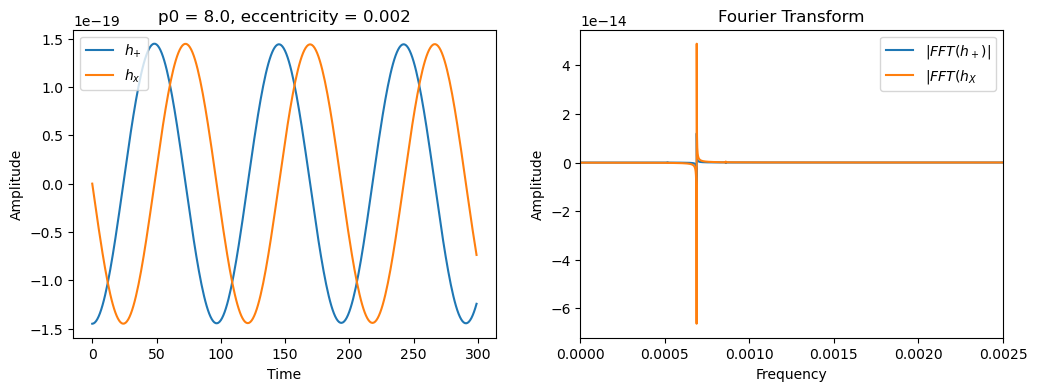

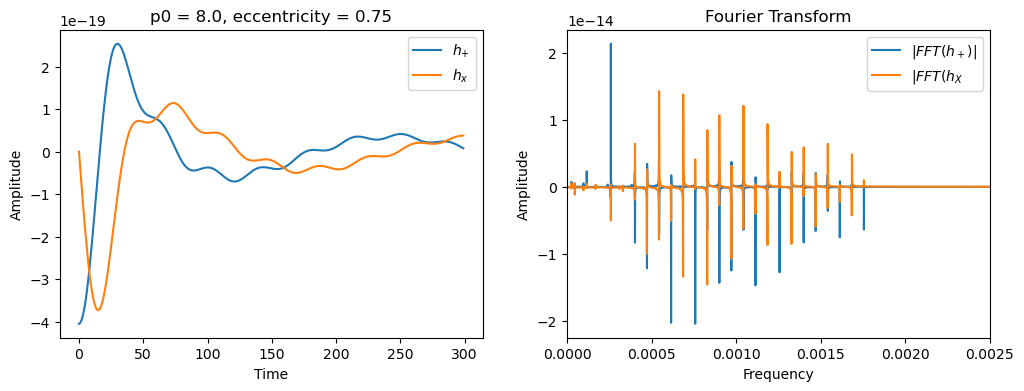

In [ ]:
r1 = data_set(5e-2, 8.0, 0.002, 15/365,0.001)
r2 = data_set(5e-2, 8.0, 0.75, 15/365,0.001)



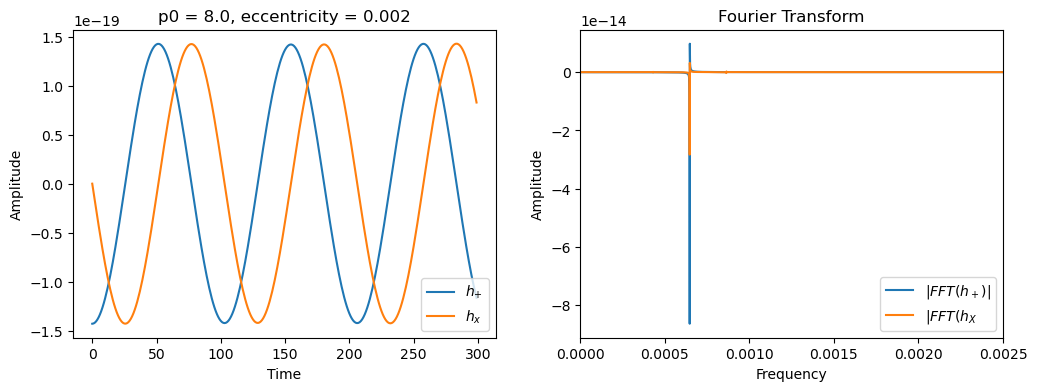

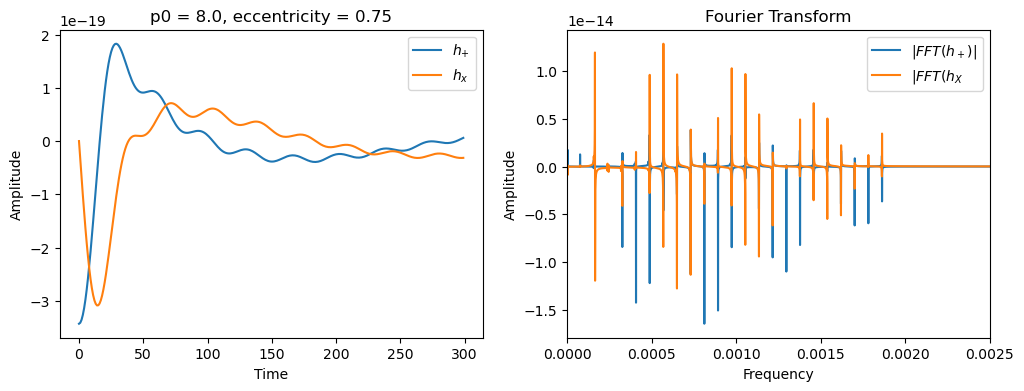

In [ ]:
r1 = data_set(5e-2, 8.0, 0.002, 15/365,0.5)
r2 = data_set(5e-2, 8.0, 0.75, 15/365,0.5)



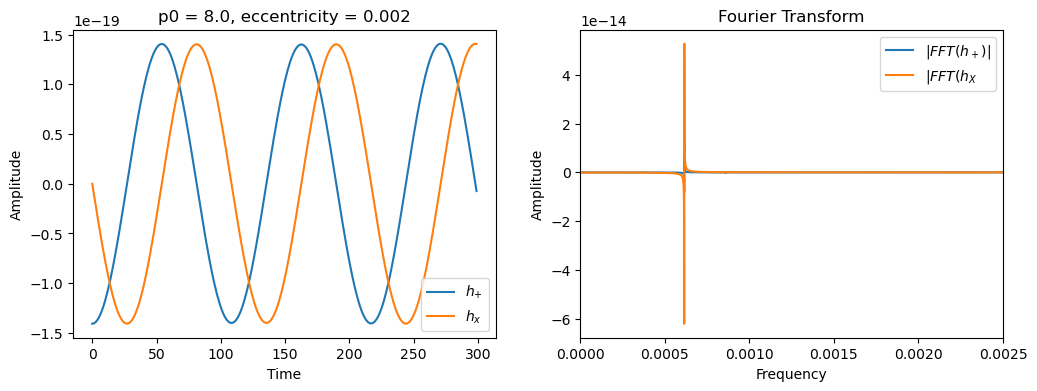

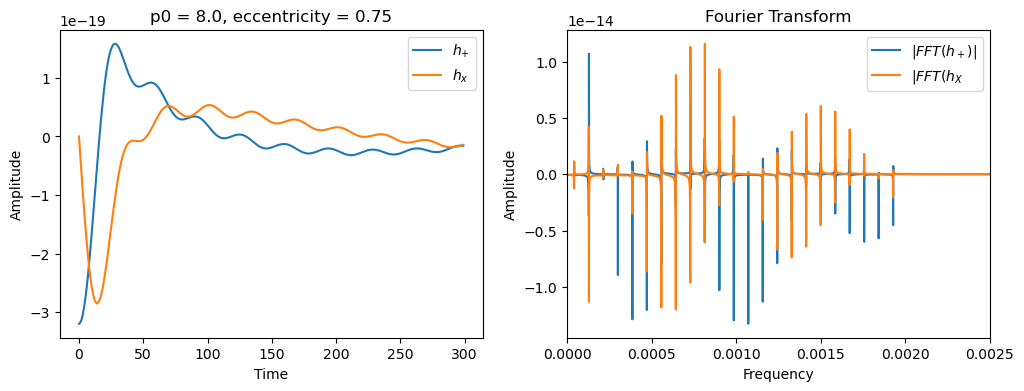

In [ ]:
r1 = data_set(5e-2, 8.0, 0.002, 15/365,0.998)
r2 = data_set(5e-2, 8.0, 0.75, 15/365,0.998)



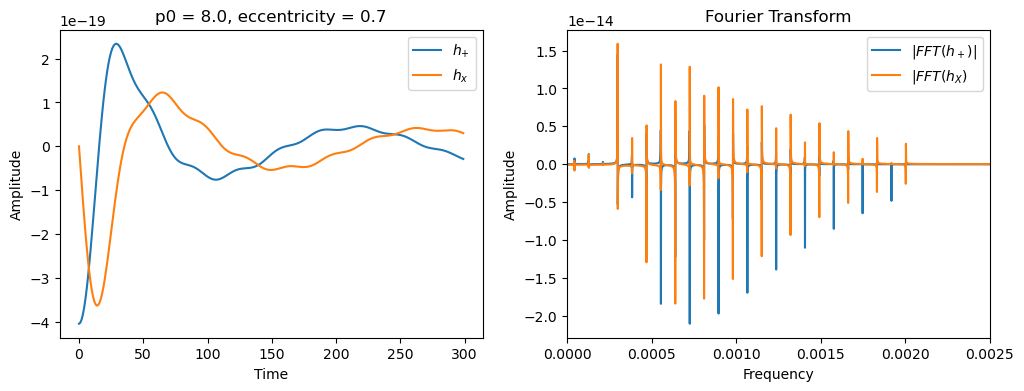

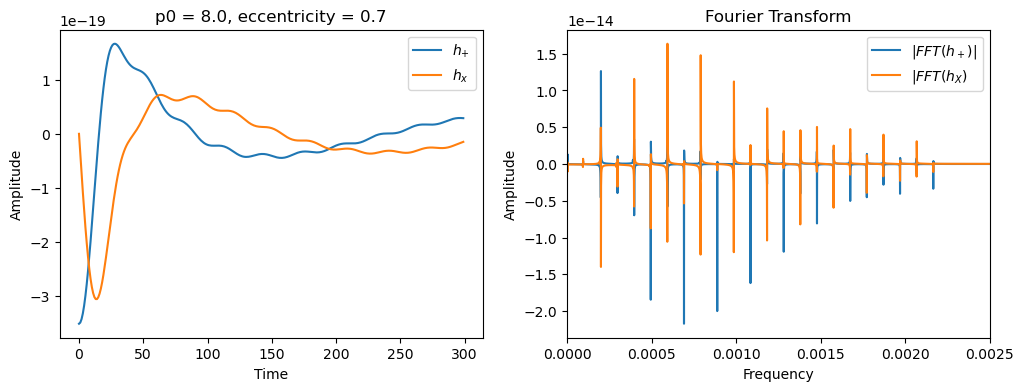

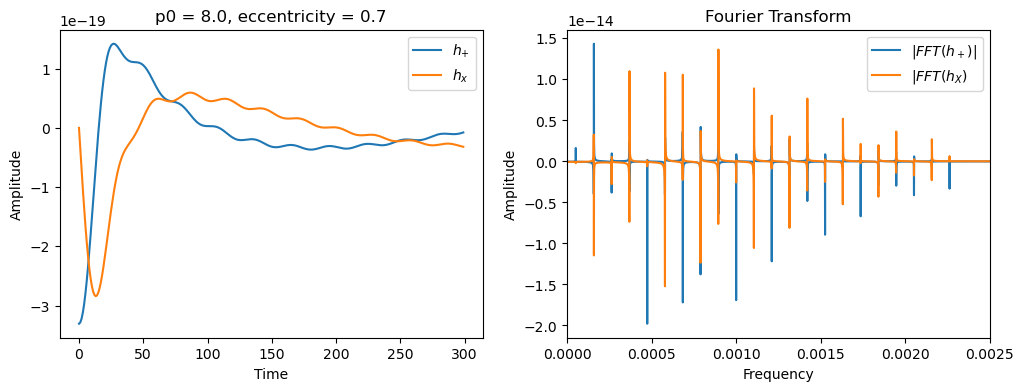

In [ ]:
l1 = data_set(5e-2,8.0, 0.7, 15/365,0.001)
l2= data_set(5e-2, 8.0, 0.7, 15/365,0.5)
l3 = data_set(5e-2,8.0, 0.7, 15/365,0.998)



In [ ]:
print (l1[-1], l2[-1], l3[-1])

2271.762596503781 2125.0898698517635 2108.1764061717695


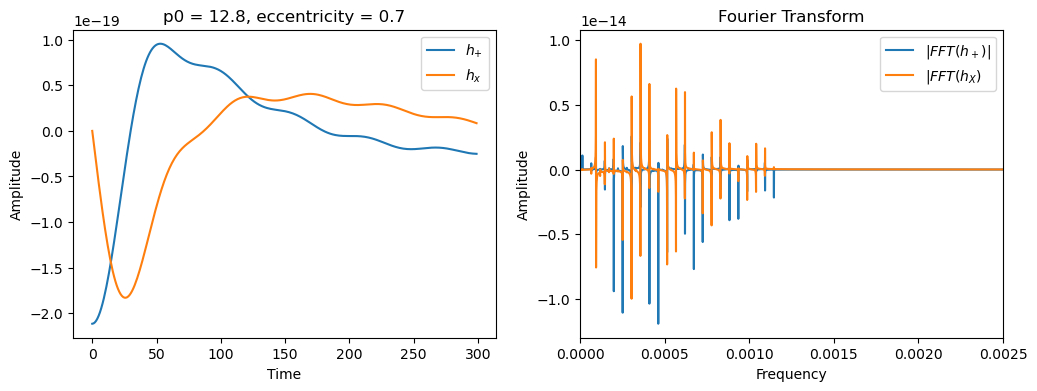

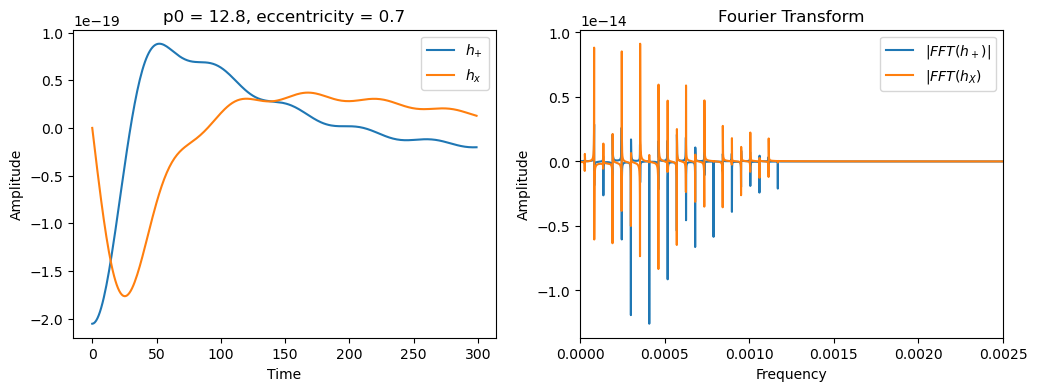

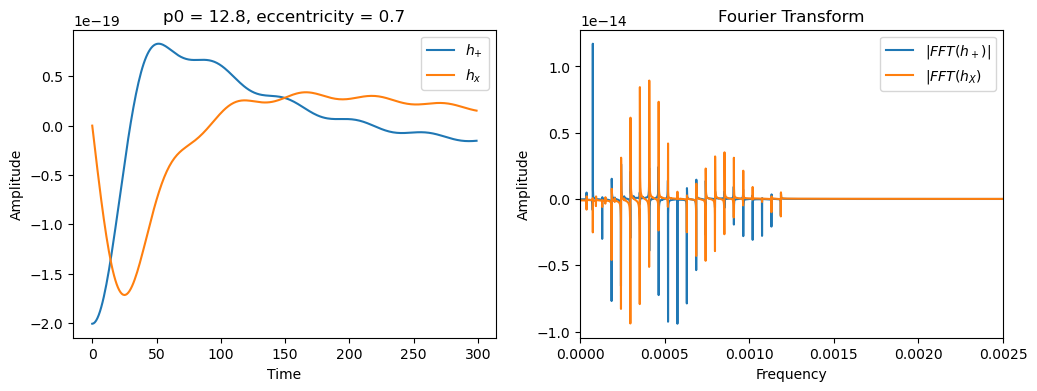

In [ ]:
l1 = data_set(5e-2,12.8, 0.7, 15/365,0.001)
l2= data_set(5e-2, 12.8, 0.7, 15/365,0.5)
l3 = data_set(5e-2,12.8, 0.7, 15/365,0.998)



In [ ]:
print (l1[-1], l2[-1], l3[-1])

357.10051434912106 357.0673492418661 370.2673850144967


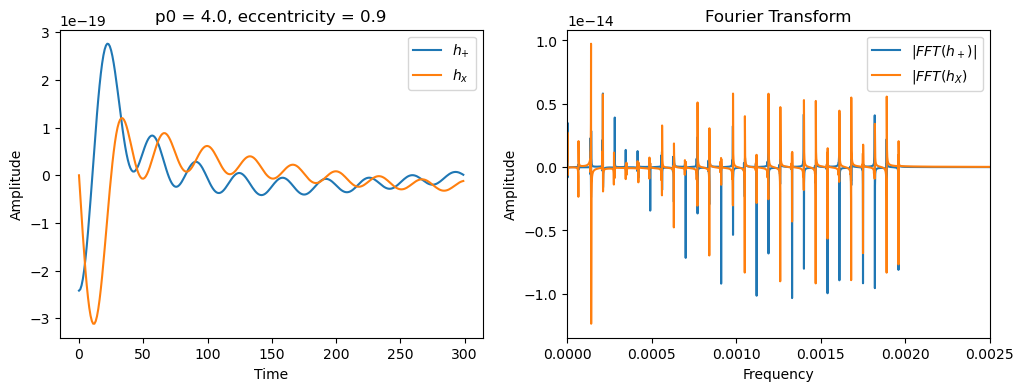

In [ ]:
# l1 = data_set(5e-2,6.0, 0.9, 15/365,0.)
# l2= data_set(5e-2, 4.0, 0.9, 15/365,0.5)
l3 = data_set(5e-2,4.0, 0.9, 15/365,0.998)



In [ ]:
print ( l2[-1], l3[-1])

783.4533196907566 569.5992525319035


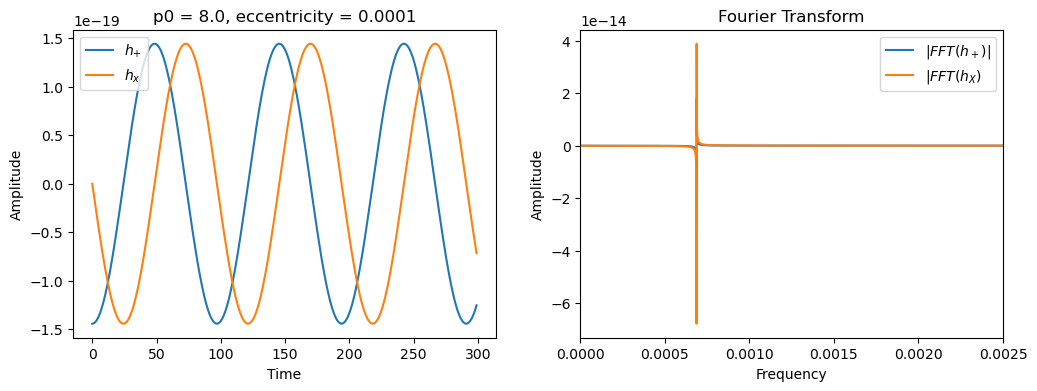

In [ ]:
l3 = data_set(5e-2,8.0, 0.0001, 15/365,0.01)


In [12]:
use_gpu = True

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [13]:
def data_setSW(mu, p0, intg_timem, e0):
    T = intg_timem
    dt = 15.0  # seconds
    M = 4.15e6
    dist1 = 0.000008277
    mu = 5e-2 # mass of the compact object in solar masses
    dist1 = 0.000008277 # distance to the source in gigaparsecs
    e0 = 0.0 # initial eccentricity
    theta = np.pi/2  # polar viewing angle
    phi = 0  # azimuthal viewing angle
    dt = 15 # time step in seconds
    p0 = p0 # initial semilatus rectum in this case our orbit is circular. thus p =r = 6.15. 
    t0 = 0.0 # initial time
    # T=0.000114155 # total time in years to generate the waveform here i take 1hr
    h = few(M, mu, p0, e0, theta, phi,  dt=dt, T=T)

    fft_TD = np.fft.fftshift(np.fft.fft(h.real)) * dt
    fft_TDX = np.fft.fftshift(np.fft.fft(h.imag)) * dt
    freq = np.fft.fftshift(np.fft.fftfreq(len(h.real), dt))
    positive_frequency_mask = (freq >= 0.0)
    a1 = freq[positive_frequency_mask]
    b1 = np.abs(fft_TD[positive_frequency_mask]) ** 2
    b2 = np.abs(fft_TDX[positive_frequency_mask]) ** 2
    pluspart = np.abs(fft_TD)**2
    crosspart = np.abs(fft_TDX)**2
    df = freq[1] - freq[0]
    integralp = np.zeros(len(pluspart))
    numerator = pluspart + crosspart
    denominator = power_spectral_density_RCLfit(freq)
    
    for i in range(len(numerator)):
        integralp[i] = numerator[i] / denominator[i]
    
    snr = np.sqrt((4 * np.sum(integralp) * df))


    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # ax1.set_xlabel('Time')
    # ax1.set_ylabel('h(t)')
    # ax1.plot(h.real[:400].get(), label=r'$ h_{+} $')
    # ax1.plot(h.imag[:400].get(), label=r'$ h_{x} $')
    # ax1.set_title(f'p0 = {p0}M, \u03B8 = {theta} rad')
    # ax1.legend()
    # ax2.plot(cp.array(freq[positive_frequency_mask]).get(), cp.array(fft_TD[positive_frequency_mask]).get(), label=r'$ |FFT(h_+)|$')
    # ax2.plot(cp.array(freq[positive_frequency_mask]).get(), cp.array(fft_TDX[positive_frequency_mask]).get(), label=r'$ |FFT(h_x)|$')

    # # ax2.plot(freq[positive_frequency_mask].get(), fft_TDX[positive_frequency_mask].get(), label=r'$ |FFT(h_X)$')
    # ax2.set_xlim(0, 0.0025)
    # ax2.set_xlabel('Frequency')
    # ax2.set_ylabel('Amplitude')
    # ax2.set_title('Fourier Transform')
    # ax2.legend()

    # plt.show()

    return  p0, a1, b1, b2 , h.real, h.imag, freq, fft_TD, fft_TDX, snr

# Example usage
# unicode of theta is 

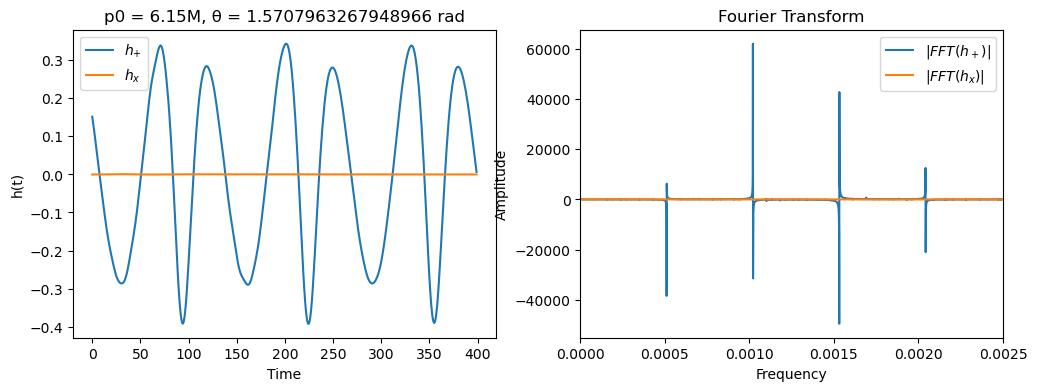

In [ ]:
r1 = data_setSW(5e-2, 6.15, 15/365, np.pi/2)

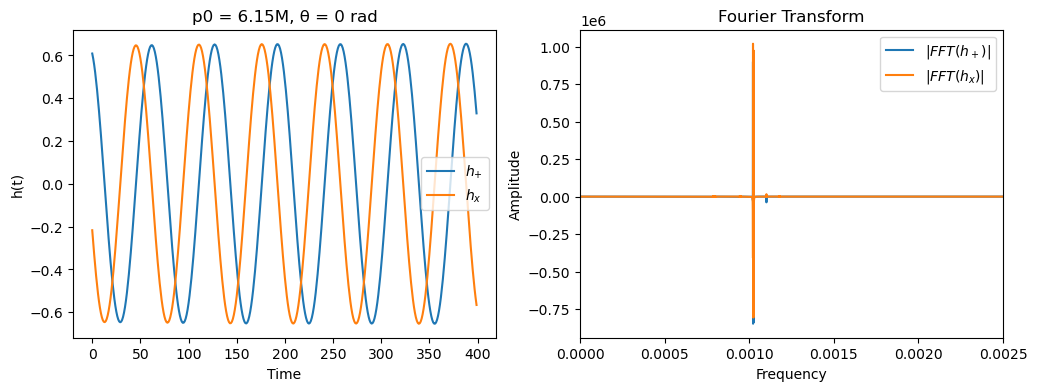

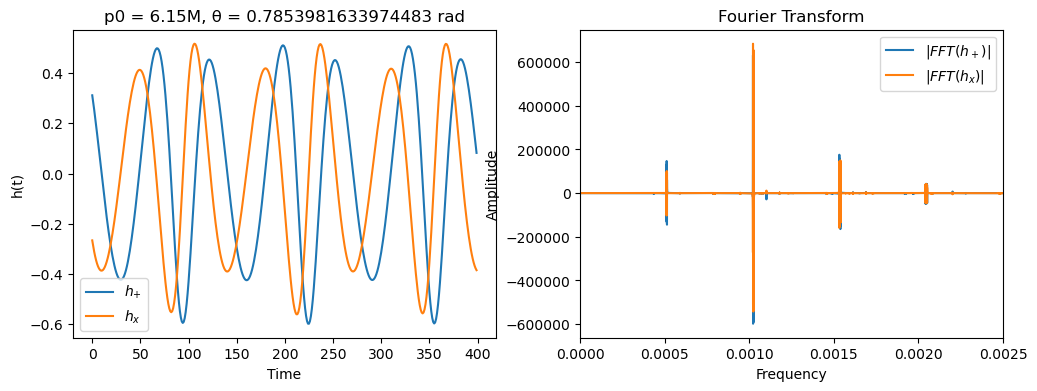

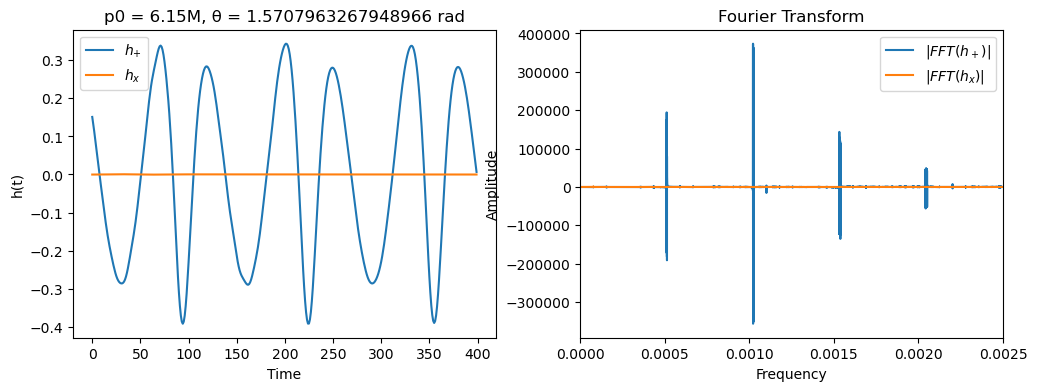

In [ ]:
for theta in [0, np.pi/4, np.pi/2]:
    r1 = data_setSW(5e-2, 6.15, 1, theta)
    

In [15]:
snrofkerr=[]
snrofsw=[]
for e0 in np.linspace(0.5, 0.9, 50):
    for p0 in np.linspace(6.15, 8, 50):
        r1 = data_set(5e-2, p0, e0, 15/365,0.998)
        r2 = data_setSW(5e-2, p0, 15/365, e0)
        snrofkerr.append(r1[-1])
        snrofsw.append(r2[-1])

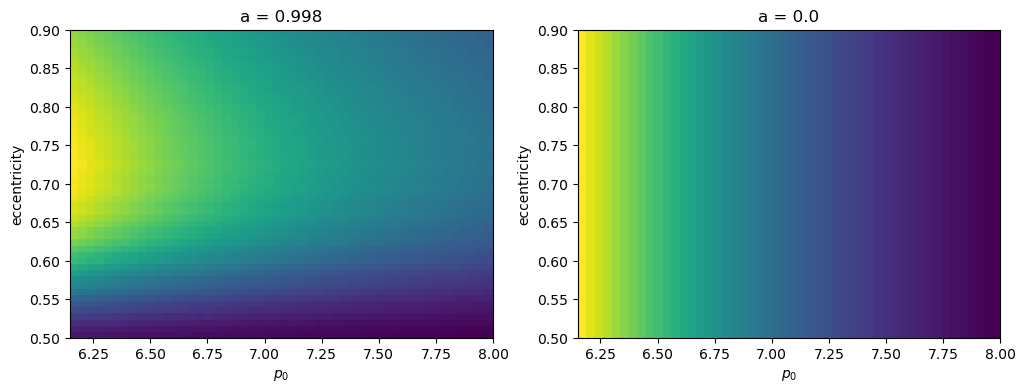

In [21]:
snrfkerr = np.array(snrofkerr)
snrfsw = np.array(snrofsw)

snr1fkerr = snrfkerr.reshape(50,50)
snr1fsw = snrfsw.reshape(50,50)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(snr1fkerr, extent=[6.15, 8, 0.5, 0.9], aspect='auto')
ax[0].set_xlabel(f'$p_0$')
ax[0].set_ylabel('eccentricity')
ax[0].set_title('a = 0.998')

ax[1].imshow(snr1fsw, extent=[6.15, 8, 0.5, 0.9], aspect='auto')
ax[1].set_xlabel(f'$p_0$')
ax[1].set_ylabel('eccentricity')
ax[1].set_title('a = 0.0')

plt.show()



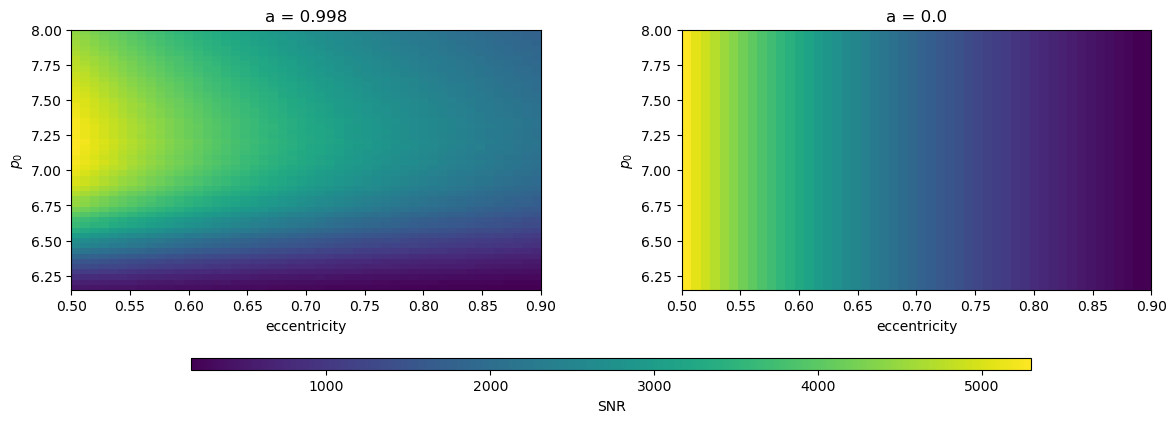

In [35]:
snrfkerr = np.array(snrofkerr)
snrfsw = np.array(snrofsw)

snr1fkerr = snrfkerr.reshape(50,50)
snr1fsw = snrfsw.reshape(50,50)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(snr1fkerr, extent=[0.5, 0.9,6.15, 8], aspect='auto')
ax[0].set_ylabel(f'$p_0$')
ax[0].set_xlabel('eccentricity')
ax[0].set_title('a = 0.998')

ax[1].imshow(snr1fsw, extent=[0.5, 0.9,6.15, 8 ], aspect='auto')
ax[1].set_ylabel(f'$p_0$')
ax[1].set_xlabel('eccentricity')
ax[1].set_title('a = 0.0')
# color bar 
norm = plt.Normalize(snr1fkerr.min(), snr1fkerr.max())


sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')

# Set common colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95, hspace=0.3, wspace=0.3)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('SNR')



plt.show()



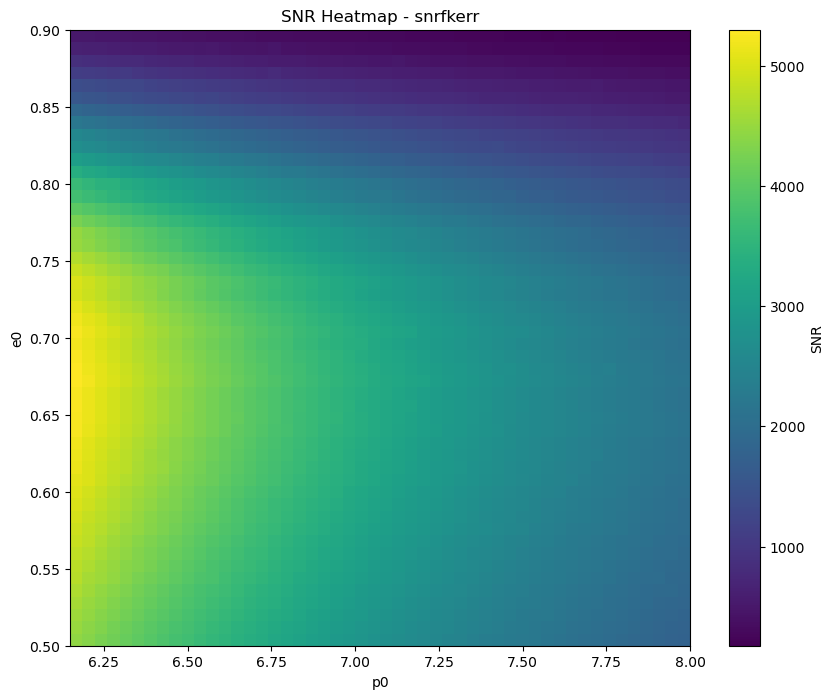

In [27]:
snrfkerr = np.array(snrofkerr)
snrfsw = np.array(snrofsw)



import numpy as np
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
e0 = np.linspace(0.5, 0.9, 2500)  # 2500 values from 0.5 to 0.9
p0 = np.linspace(6.15, 8, 2500)   # 2500 values from 6.15 to 8


snrfkerr=np.reshape(snrfkerr, (50, 50))
snrfsw=np.reshape(snrfsw, (50, 50))

# Plotting
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.imshow(snrfkerr, extent=[p0[0], p0[-1], e0[0], e0[-1]], aspect='auto', origin='lower', cmap='viridis')

plt.colorbar(label='SNR')  # Add colorbar with label
plt.xlabel('p0')
plt.ylabel('e0')
plt.title('SNR Heatmap - snrfkerr')
plt.grid(False)  
# Optional: turn off grid lines
colorbar = plt.colorbar()
colorbar.set_label('SNR', rotation=270)

plt.show()

